In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse(log):
    benchmarks = []
    for line in log.split('\n'):
        match = re.search( r'\[(.+)\]\s+mean =\s+(.+)\(ns\)\s+sd =\s+(.+)\(ns\)\s+nsample =\s+(\d+)', line)
        if match:
            benchmarks.append({
                'mso': match.group(1).strip(),
                'mean_ns': float(match.group(2)),
                'std_ns': float(match.group(3)),
                'nsamples': int(match.group(4))
            })
    return pd.DataFrame(benchmarks)

In [5]:
from glob import glob
from os.path import basename

def read_measured(path_glob):
    measured = []
    for path in glob(path_glob):
        if 'spmm' in path:
            continue
        match = re.search(r'(.+)-(\d+)\.log', basename(path))
        batch_name = match.group(1)
        simd_width = int(match.group(2))
        size = None

        with open(path) as f:
            log = f.read()

            # setop
            if (match_a := re.search(r'Load a: (\d+)', log)) and (match_b := re.search(r'Load b: (\d+)', log)):
                size = int(match_a.group(1)) + int(match_b.group(1))
            # joinop
            elif (match_a := re.search(r'Load aidx: (\d+)', log)) and (match_b := re.search(r'Load bidx: (\d+)', log)):
                size = int(match_a.group(1)) + int(match_b.group(1))
            # join-*
            elif match := re.search(r'Tensor\s+: mode =  (\d), .+, nnz =  (\d+)', log):
                size = 2 * int(match.group(1)) * int(match.group(2))
            # sort & sortkv
            elif match := re.search(r'Generated random vector length = (\d+)', log):
                size = int(match.group(1))

            df = parse(log)
            if len(df) == 0:
                continue
            df = df.loc[df['mean_ns'].notna()]
            df['batch_name'] = batch_name
            df['simd_width'] = simd_width
            df.loc[df['mso'].str.contains('Scalar'), 'simd_width'] = 1
            df['size'] = size
            df['throughput'] = df['size'] / df['mean_ns']
            measured.append(df)

    return pd.concat(measured)

# Experiment 1

In [ ]:
measured = read_measured('results/windows/experiment-1/*.log')

In [120]:
set_union = measured[measured['batch_name'].isin(('setop', 'joinop'))].copy()
set_union['mso'] = set_union['mso'].str.replace(' Scalar', '')
set_union['mso'] = set_union['mso'].str.replace(' SIMD', '')
set_union['mso'] = set_union.apply(lambda x: 'Set-' + x['mso'] if x['batch_name'] == 'setop' else x['mso'], axis=1)
set_union = set_union.sort_values(by='simd_width')
set_union['mso'].unique()

array(['Join-Inner', 'Join-Left-Ex', 'Set-Diff', 'Join-Outer-Ex',
       'Set-XOR', 'Set-Intersect', 'Join-Left', 'Join-Full-Outer',
       'Set-Union'], dtype=object)

C:\Users\Jon\AppData\Local\Temp\ipykernel_28496\3654055611.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors
C:\Users\Jon\AppData\Local\Temp\ipykernel_28496\3654055611.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_container = plt.bar([j + i * group_width for j in range(num_msos)], group['throughput'], width=group_width, label=simd, color=plt.cm.get_cmap('tab20')(i))


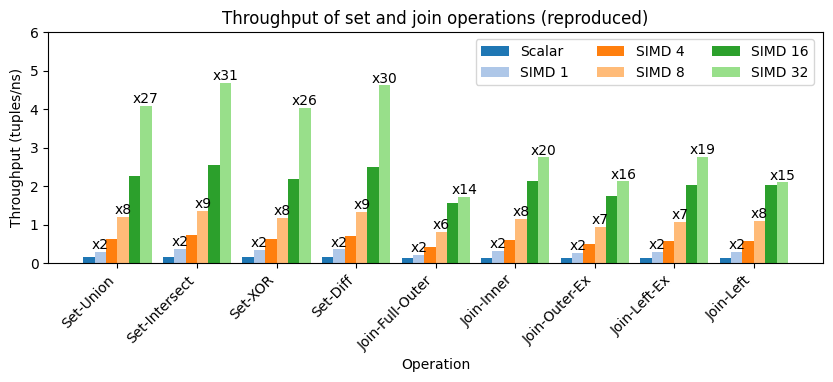

In [154]:
set_union = measured[measured['batch_name'].isin(('setop', 'joinop'))].copy()
set_union['mso'] = set_union['mso'].str.replace(' Scalar', '')
set_union['mso'] = set_union['mso'].str.replace(' SIMD', '')
set_union['mso'] = set_union.apply(lambda x: 'Set-' + x['mso'] if x['batch_name'] == 'setop' else x['mso'], axis=1)

# Order mso groups
ordered_msos = ['Set-Union', 'Set-Intersect', 'Set-XOR', 'Set-Diff', 'Join-Full-Outer', 'Join-Inner', 'Join-Outer-Ex', 'Join-Left-Ex', 'Join-Left']
set_union['mso'] = pd.Categorical(set_union['mso'], categories=ordered_msos, ordered=True)
set_union = set_union.sort_values(['mso', 'simd_width'])

# Group data by 'simd_width'
grouped = set_union.groupby('simd_width')

# Calculate speedups compared to simd_width=1
simd_width_1 = set_union[set_union['simd_width'] == 1].set_index('mso')['throughput']
set_union['speedup'] = set_union.apply(lambda x: x['throughput'] / simd_width_1.loc[x['mso']], axis=1)

# Plotting the bar chart
plt.figure(figsize=(10, 3))
colors = plt.cm.get_cmap('tab20').colors

msos = set_union['mso'].unique()
num_msos = len(msos)
num_groups = len(grouped)
group_width = 1 / (num_groups + 1)

for i, (simd, group) in enumerate(grouped):
    bar_container = plt.bar([j + i * group_width for j in range(num_msos)], group['throughput'], width=group_width, label=simd, color=plt.cm.get_cmap('tab20')(i))

    # Add black text labels on top of each bar when i is odd
    if i % 2 == 1:
        for bar, speedup in zip(bar_container, group['speedup']):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"x{int(round(speedup))}", ha='center', va='bottom', color='black')

plt.xlabel('Operation')
plt.ylabel('Throughput (tuples/ns)')
plt.title('Throughput of set and join operations (reproduced)')

# Set x-axis ticks and labels
tick_positions = [j + 0.5 * group_width * (num_groups - 1) for j in range(num_msos)]
plt.xticks(tick_positions, msos, rotation=45, ha='right')

# Set y-axis limit
plt.ylim(top=6)

# Add legend
legend_labels = [f'Scalar'] + [f'SIMD {int(simd)}' for simd in set_union['simd_width'].unique()]
legend = plt.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.77, 1), ncol=3)

# Remove the title from the legend
legend.set_title(None)

plt.show()

In [40]:
import requests

expected_logs = [
    ('setop', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/SetOperation/SetOperation.md'),
    ('joinop', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/JoinOp/JoinOp.md'),
    ('sort', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/Sort/Sort_10k.md'),
    ('sortkv', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/Sort/SortKV_10k.md')
]

rows = []
for batch_name, url in expected_logs:

    log = requests.get(url).text

    simd_width = None
    for line in log.split('\n'):
        line = line.strip()
        if not line:
            continue

        match = re.search(r'^# (?:v=)?(\d+)$', line)
        if match:
            simd_width = int(match.group(1))

        if simd_width:
            df = parse(line)
            df['batch_name'] = batch_name
            df['simd_width'] = simd_width
            rows.append(df)


join_expected_url = 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/ComplexJoin/complexJoin.md'

log = requests.get(join_expected_url).text

batch_name = None
for line in log.split('\n'):
    line = line.strip()
    if not line:
        continue

    if line.startswith('# key=(int)'):
        batch_name = 'join-*-vector'
    elif line.startswith('# key=(int,int)'):
        batch_name = 'join-*-matrix'
    elif line.startswith("# key=(int,int,int)"):
        batch_name = 'join-*-tensor'
    else:
        df = parse(line)
        df['batch_name'] = batch_name
        df['simd_width'] = int(re.search(r'.+ SIMD (\d+)', line).group(1))
        rows.append(df)

expected = pd.concat(rows)
expected

,batch_name,simd_width,mso,mean_ns,std_ns,nsamples
0,setop,4,Union Scalar,133000.0,0.0,1.0
0,setop,4,Union SpSp,67800.0,633.0,2.0
0,setop,4,Intersect Scalar,133000.0,0.0,1.0
0,setop,4,Intersect SpSp,54100.0,82.0,2.0
0,setop,4,XOR Scalar,131000.0,0.0,1.0
...,...,...,...,...,...,...
0,join-*-tensor,32,Mul SIMD,14600.0,59.0,3.0
0,join-*-tensor,32,Mul ReIm SIMD,19500.0,80.6,3.0
0,join-*-tensor,64,Add SIMD,20300.0,43.3,3.0
0,join-*-tensor,64,Mul SIMD,14200.0,73.6,3.0


In [94]:
comparison = pd.merge(
    left=measured[['mso', 'simd_width', 'mean_ns', 'std_ns']].rename(
        columns={'mean_ns': 'mean_measured', 'std_ns': 'std_measured'}),
    right=expected[['mso', 'simd_width', 'mean_ns', 'std_ns']].rename(
        columns={'mean_ns': 'mean_expected', 'std_ns': 'std_expected'}),
    on=['mso', 'simd_width']
)
comparison['diff'] = comparison['mean_measured'] - comparison['mean_expected']
comparison['diff_ratio'] = comparison['diff'] / comparison['mean_expected']
comparison['abs_diff_percent'] = abs(comparison['diff_ratio']) * 100
comparison = comparison.sort_values(by='abs_diff_percent', ascending=False)
comparison

,mso,simd_width,mean_measured,std_measured,mean_expected,std_expected,diff,diff_ratio,abs_diff_percent
6,XOR SIMD,8,31600.0,537.0,30800.0,487.0,800.0,0.025974,2.597403
12,Union SIMD,32,8800.0,75.8,8990.0,63.7,-190.0,-0.021135,2.113459
4,Union SIMD,8,31900.0,324.0,32500.0,250.0,-600.0,-0.018462,1.846154
14,XOR SIMD,32,9040.0,386.0,8880.0,281.0,160.0,0.018018,1.801802
8,Union SIMD,16,16400.0,110.0,16700.0,87.8,-300.0,-0.017964,1.796407
10,XOR SIMD,16,16800.0,428.0,16600.0,403.0,200.0,0.012048,1.204819
2,XOR SIMD,4,59000.0,602.0,58400.0,668.0,600.0,0.010274,1.027397
0,Union SIMD,4,67900.0,546.0,67300.0,430.0,600.0,0.008915,0.891530
1,Intersect SIMD,4,54400.0,79.5,54800.0,765.0,-400.0,-0.007299,0.729927
13,Intersect SIMD,32,7790.0,63.1,7820.0,75.0,-30.0,-0.003836,0.383632


In [95]:
comparison['abs_diff_percent'].mean()

0.6661124263892003

In [96]:
(comparison['std_expected'] <= comparison['diff'].abs()).mean()

0.28

In [ ]:
# complexjoin
# sort
# spmm

# Experiment 2: Imbalance and Overlap

In [17]:
baseline = read_measured('results/windows/experiment-1/setop-*.log')
baseline

,mso,mean_ns,std_ns,nsamples,batch_name,simd_width,size,throughput
1,Union SIMD,16500.0,118.0,5,setop,16,20000,1.212121
3,Intersect SIMD,14600.0,63.6,5,setop,16,20000,1.369863
5,XOR SIMD,16900.0,418.0,5,setop,16,20000,1.183432
7,Diff SIMD,15000.0,40.9,5,setop,16,20000,1.333333
1,Union SIMD,8850.0,77.1,5,setop,32,20000,2.259887
3,Intersect SIMD,7820.0,62.2,5,setop,32,20000,2.557545
5,XOR SIMD,9090.0,379.0,5,setop,32,20000,2.200220
7,Diff SIMD,7980.0,39.9,5,setop,32,20000,2.506266
0,Union Scalar,131000.0,331.0,5,setop,1,20000,0.152672
1,Union SIMD,67500.0,561.0,5,setop,4,20000,0.296296


In [18]:
skewed = read_measured('results/windows/experiment-2/*.log')
skewed

,mso,mean_ns,std_ns,nsamples,batch_name,simd_width,size,throughput
1,Union SIMD,27600.0,84.2,5,setop-20k_1,16,19998,0.724565
3,Intersect SIMD,27500.0,67.9,5,setop-20k_1,16,19998,0.727200
5,XOR SIMD,28200.0,71.4,5,setop-20k_1,16,19998,0.709149
7,Diff SIMD,28200.0,45.9,5,setop-20k_1,16,19998,0.709149
1,Union SIMD,14800.0,83.9,5,setop-20k_1,32,19998,1.351216
3,Intersect SIMD,14700.0,65.6,5,setop-20k_1,32,19998,1.360408
5,XOR SIMD,15100.0,70.9,5,setop-20k_1,32,19998,1.324371
7,Diff SIMD,15000.0,44.4,5,setop-20k_1,32,19998,1.333200
0,Union Scalar,33300.0,60.7,5,setop-20k_1,1,19998,0.600541
1,Union SIMD,110000.0,89.7,5,setop-20k_1,4,19998,0.181800


In [20]:
comparison = pd.merge(
    left=baseline[['mso', 'simd_width', 'throughput']].rename(columns={'throughput': 'throughput_baseline'}),
    right=skewed[['mso', 'simd_width', 'throughput']].rename(columns={'throughput': 'throughput_skewed'}),
    on=['mso', 'simd_width']
)
comparison['diff'] = comparison['throughput_skewed'] - comparison['throughput_baseline']
comparison['diff_ratio'] = comparison['diff'] / comparison['throughput_baseline']
comparison['abs_diff_percent'] = abs(comparison['diff_ratio']) * 100
comparison = comparison.sort_values(by='abs_diff_percent', ascending=False)
comparison

,mso,simd_width,throughput_baseline,throughput_skewed,diff,diff_ratio,abs_diff_percent
10,Intersect Scalar,1,0.152672,1.142743,0.990071,6.484966,648.496571
14,Diff Scalar,1,0.155039,0.691972,0.536934,3.463221,346.322145
8,Union Scalar,1,0.152672,0.600541,0.447869,2.933541,293.354054
12,XOR Scalar,1,0.153846,0.600541,0.446694,2.903514,290.351351
15,Diff SIMD,4,0.358423,0.175421,-0.183002,-0.510575,51.057526
11,Intersect SIMD,4,0.369004,0.181800,-0.187204,-0.507322,50.732200
13,XOR SIMD,4,0.338409,0.175421,-0.162988,-0.481631,48.163079
23,Diff SIMD,8,0.704225,0.366264,-0.337962,-0.479905,47.990549
21,Intersect SIMD,8,0.722022,0.376610,-0.345411,-0.478395,47.839492
19,Diff SIMD,64,4.618938,2.450735,-2.168202,-0.469416,46.941581


# Experiment 3: Setop with different distributions

# Experiment 4: Sort with different distributions

# Experiment 5: Measure time per SIMD primitive

In [23]:
# setop
# join
# complexjoin
# sort

In [ ]:
# Sorting with different distributions (presorted?)
# Time per SIMD instruction

# Review how code is implemented: easy to use, no details on how it works or how to replicate the design